# Lab ML for DS SS23
## Project 2
#### Jan Jascha Jestel (5547158)
#### Mustafa Suman (5564676)
#### Gabriele Inciuraite (5208806)

In [3]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.io import loadmat
from scipy.spatial.distance import cdist, pdist


# 1. Importing the QM7 Dataset

In [4]:
# The QM7 dataset consists of 7165 organic molecules, each of which is composed of up to 23 atoms.
qm7 = loadmat("./qm7.mat")
print(qm7.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'R', 'Z', 'T', 'P'])


In [5]:
# R (7165×23×3) contains for each molecule and atom a triplet representing the 3d coordinates
display(qm7['R'].shape)
display(qm7['R'][0])

(7165, 23, 3)

array([[ 1.886438  , -0.00464873, -0.00823921],
       [ 3.9499245 , -0.00459203,  0.00782347],
       [ 1.1976895 ,  1.9404842 ,  0.00782347],
       [ 1.1849339 , -0.99726516,  1.6593875 ],
       [ 1.2119948 , -0.9589793 , -1.710958  ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

In [6]:
# Z (7165×23) contains for each molecule and atom of the molecule the corresponding atomic number

# 0 == no atom at this index
# 1 == hydrogen (H)
# 6 == carbon (C)
# 7 == nitrogen (N) 
# 8 == oxygen (O)
# 16 == sulfur (S)
display(qm7['Z'].shape)
display(qm7['Z'][0])

(7165, 23)

array([6., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

(1, 7165)

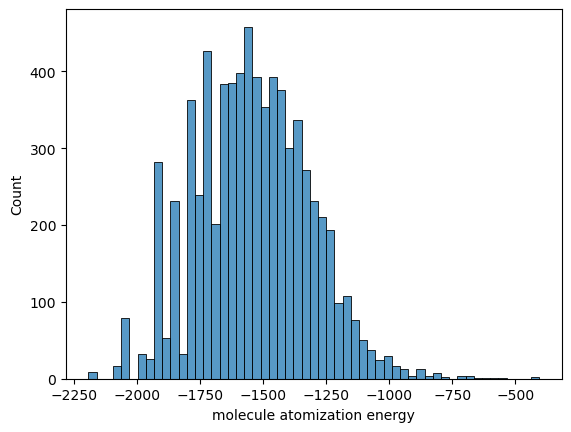

In [7]:
# T (1 x 7165) contains for each molecule the atomization energy (computed via quantum-chemical simulation)
display(qm7['T'].shape)

g = sns.histplot(qm7['T'][0])
g.set_xlabel('molecule atomization energy')
plt.show()

# TESTS FOR 1.1 Visualizing Molecules "quick and dirty approach"

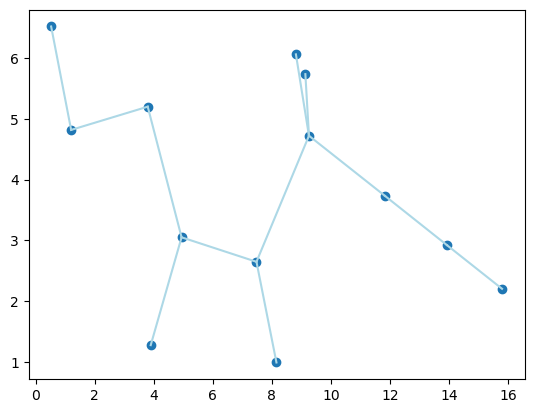

In [8]:
nr = 6400

mol = qm7["R"][nr]
sym = qm7["Z"][nr]

sym = sym[sym > 0]
mol = mol[: len(sym)]

plt.scatter(x=mol[:, 0], y=mol[:, 1])


# generate bonds
thresh = 3

mask = np.argwhere(pdist(mol, metric="euclidean") < thresh)[:, 0]
bonds = np.vstack(np.triu_indices(len(mol), 1)).T[mask]

for i in range(len(bonds)):
    plt.plot(mol[bonds[i]][:, 0], mol[bonds[i]][:, 1], color="lightblue")


In [9]:
from ase import Atoms
import nglview
import ase.visualize

system = Atoms(positions=mol, symbols=sym)
# ase.visualize.view(system, viewer="x3d")

view = nglview.show_ase(system)
view.add_ball_and_stick() # HOW TO SPECIFY BONDS?????
view


NGLWidget()

In [10]:
# Other viz approaches
# https://www.kaggle.com/code/mykolazotko/3d-visualization-of-molecules-with-plotly
# nglview


# 2 Data Representation, ML Model and Explanations

# TEST FOR 2.1 Data Representation

In [11]:
# first try described representation
# 1 == hydrogen (H)
# 6 == carbon (C)
# 7 == nitrogen (N)
# 8 == oxygen (O)
# 16 == sulfur (S)


z = qm7["Z"].astype(np.int8)

z[z == 1] = 1
z[z == 6] = 2
z[z == 7] = 3
z[z == 8] = 4
z[z == 16] = 5

Z_hot = np.eye(6)[z]


Z_hot = Z_hot[:, :, 1:]  # drop 0 dimension

x = np.sum(Z_hot, axis=1)

display(x.shape)
x


(7165, 5)

array([[ 4.,  1.,  0.,  0.,  0.],
       [ 6.,  2.,  0.,  0.,  0.],
       [ 4.,  2.,  0.,  0.,  0.],
       ...,
       [ 9.,  6.,  1.,  0.,  0.],
       [10.,  7.,  0.,  0.,  0.],
       [12.,  7.,  0.,  0.,  0.]])

# TEST FOR 2.2 Ridge Regression Model

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

# split train / test 
X_train, X_test, y_train, y_test = train_test_split(x, qm7['T'][0], test_size=0.3, random_state=42)

# center data and target
X_train_mean = np.mean(X_train, axis=0)
y_train_mean = np.mean(y_train)

X_train = X_train - X_train_mean
X_test = X_test - X_train_mean

y_train = y_train - y_train_mean
y_test = y_test - y_train_mean

In [13]:
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedKFold, GridSearchCV

ridge = Ridge(alpha=1.0)

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

# scores = cross_validate(ridge, X_train, y_train, cv=cv, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), return_train_score=True)
# scores.keys()

alpha_values = np.log(np.logspace(0, 5, 100, base=np.e))
grid = dict(alpha = alpha_values)
search = GridSearchCV(ridge, grid, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), cv=cv, n_jobs=-1, refit = 'neg_mean_squared_error')

results = search.fit(X_train, y_train)


In [14]:
display(results.cv_results_.keys())

results.cv_results_['mean_test_r2']

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'params', 'split0_test_r2', 'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'split5_test_r2', 'split6_test_r2', 'split7_test_r2', 'split8_test_r2', 'split9_test_r2', 'split10_test_r2', 'split11_test_r2', 'split12_test_r2', 'split13_test_r2', 'split14_test_r2', 'split15_test_r2', 'split16_test_r2', 'split17_test_r2', 'split18_test_r2', 'split19_test_r2', 'split20_test_r2', 'split21_test_r2', 'split22_test_r2', 'split23_test_r2', 'split24_test_r2', 'split25_test_r2', 'split26_test_r2', 'split27_test_r2', 'split28_test_r2', 'split29_test_r2', 'split30_test_r2', 'split31_test_r2', 'split32_test_r2', 'split33_test_r2', 'split34_test_r2', 'split35_test_r2', 'split36_test_r2', 'split37_test_r2', 'split38_test_r2', 'split39_test_r2', 'split40_test_r2', 'split41_test_r2', 'split42_test_r2', 'split43_test_r2', 'split44_test_r2', 'split45_test_r2', 'split46_test_r2', 'split47_te

array([0.99179245, 0.99179245, 0.99179245, 0.99179244, 0.99179243,
       0.99179241, 0.99179239, 0.99179237, 0.99179234, 0.99179231,
       0.99179227, 0.99179223, 0.99179218, 0.99179213, 0.99179208,
       0.99179202, 0.99179196, 0.99179189, 0.99179182, 0.99179175,
       0.99179167, 0.99179159, 0.9917915 , 0.99179141, 0.99179132,
       0.99179122, 0.99179112, 0.99179101, 0.9917909 , 0.99179079,
       0.99179067, 0.99179055, 0.99179042, 0.99179029, 0.99179015,
       0.99179002, 0.99178987, 0.99178973, 0.99178958, 0.99178942,
       0.99178926, 0.9917891 , 0.99178893, 0.99178876, 0.99178859,
       0.99178841, 0.99178823, 0.99178804, 0.99178785, 0.99178766,
       0.99178746, 0.99178726, 0.99178706, 0.99178685, 0.99178663,
       0.99178642, 0.9917862 , 0.99178597, 0.99178574, 0.99178551,
       0.99178527, 0.99178503, 0.99178479, 0.99178454, 0.99178429,
       0.99178404, 0.99178378, 0.99178351, 0.99178325, 0.99178298,
       0.9917827 , 0.99178242, 0.99178214, 0.99178186, 0.99178

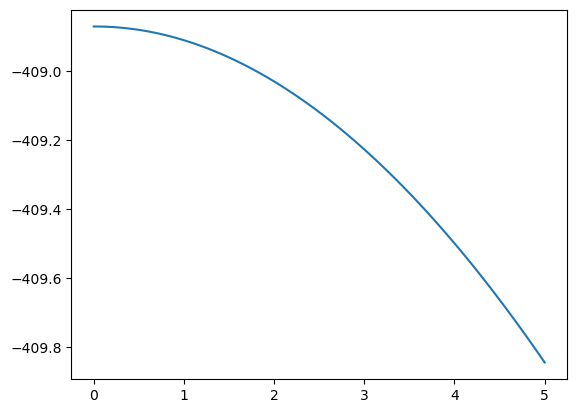

In [15]:
ax = sns.lineplot(x = alpha_values, y=results.cv_results_['mean_test_neg_mean_squared_error'], errorbar=None)

<ErrorbarContainer object of 3 artists>

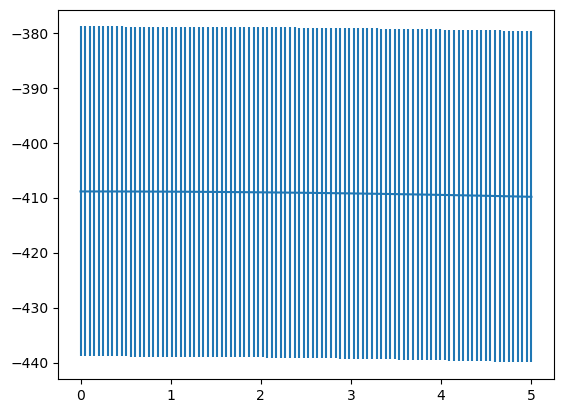

In [16]:
plt.errorbar(x = alpha_values, y=results.cv_results_['mean_test_neg_mean_squared_error'], yerr=results.cv_results_['std_test_neg_mean_squared_error'])

In [17]:
# s = np.concatenate([results.cv_results_['split' + str(i) + '_test_r2'] for i in range(10)])

# a = np.concatenate([grid['alpha'] for i in range(10)])

# d = pd.DataFrame({'alpha':a, 'score':s})

# sns.lineplot(data = d, x='alpha', y='score')


R2: 0.9919575972670127
MSE: 403.69255234309014
MAE: 15.467094890807335


<AxesSubplot: >

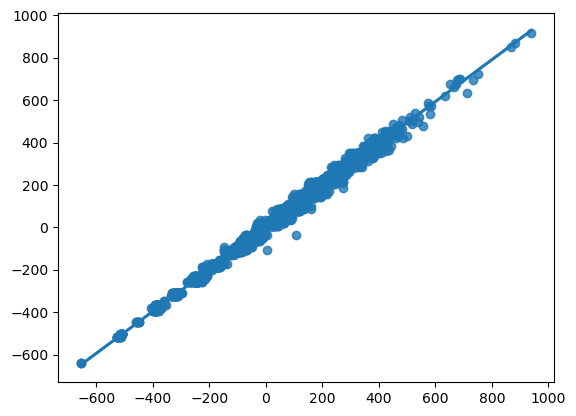

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)
print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
sns.regplot(x=y_test, y=y_pred)

In [19]:
# TEST - USE RIDGECV

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
model = RidgeCV(alphas=np.arange(0.01, 5, 0.01), cv=cv, scoring='neg_mean_absolute_error') # TODO log scale like described in task? np.log(np.logspace(0, 5, 100, base=np.e))
model.fit(X_train, y_train)
print('alpha: %f' % model.alpha_)

# smallest alpha always best TODO did i do anything wrong here or before?

alpha: 0.010000


In [20]:
# this aligns with the given mae of 15 kcal/mol
mean_absolute_error(y_test, model.predict(X_test))

15.460764787547868

In [21]:
# # training on just 10 samples is already very good # TODO anything wrong here or before?
# test = Ridge(alpha = 1)
# test.fit(X_train[:10], y_train[:10])
# test.score(X_test, y_test)

# 2.3 Deeper Insights with Explanations + 3 Experiments + 3.1 Simple atom-based Representation
# Isn't that what we already did before?

In [22]:
print("MSE =", mean_absolute_error(y_test, model.predict(X_test)))
print("Ri =", model.coef_)


MSE = 15.460764787547868
Ri = [ -68.68727171 -157.40740317 -102.41317782 -101.15313225  -80.5394613 ]


<AxesSubplot: >

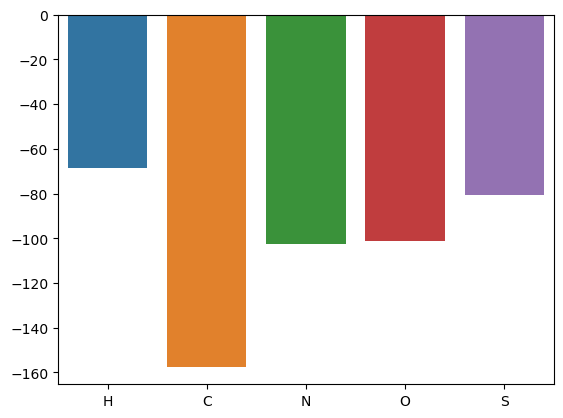

In [23]:
sns.barplot(x=["H", "C", "N", "O", "S"], y=model.coef_)
# TODO Compare the produced insights with existing chemical knowledge or the literature.

# TEST FOR 3.2 Models with Pairs of Atoms

### Part A

In [92]:
mol = qm7['R'][0][:5,]
mol

array([[ 1.886438  , -0.00464873, -0.00823921],
       [ 3.9499245 , -0.00459203,  0.00782347],
       [ 1.1976895 ,  1.9404842 ,  0.00782347],
       [ 1.1849339 , -0.99726516,  1.6593875 ],
       [ 1.2119948 , -0.9589793 , -1.710958  ]], dtype=float32)

In [93]:
from scipy.spatial.distance import pdist

dist = pdist(mol, metric='euclidean')
dist

array([2.06354897, 2.06353445, 2.06358284, 2.06515662, 3.37018079,
       3.37019828, 3.3706563 , 3.3701925 , 3.37065317, 3.37067155])

In [94]:
theta_1 = 2
theta_m = 6
m = 10

intervals = np.linspace(theta_1, theta_m, m)
intervals

array([2.        , 2.44444444, 2.88888889, 3.33333333, 3.77777778,
       4.22222222, 4.66666667, 5.11111111, 5.55555556, 6.        ])

In [97]:
# which index for phi A needs to be 1 if we use hard indicator function
interval_size = ((theta_m - theta_1) / (m - 1))
indices = np.floor((dist - theta_1) / interval_size).astype(int)
indices

array([0, 0, 0, 0, 3, 3, 3, 3, 3, 3])

In [98]:
phi_A_E = np.zeros((len(indices), m), dtype=int)
phi_A_E[tuple(np.array(list(zip(range(len(indices)), indices))).T)] = 1
phi_A_E

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [ ]:
mean = intervals[:-2] + interval_size
mean

In [100]:
from scipy.stats import norm

phi_A_E_soft = np.zeros(phi_A_E.shape)

for i, mu in enumerate(mean):
    phi_A_E_soft[:,i] = norm.pdf(dist, loc = mu, scale=.5)

np.round(phi_A_E_soft, decimals=3)

array([[0.597, 0.204, 0.032, 0.002, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.597, 0.204, 0.032, 0.002, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.597, 0.204, 0.032, 0.002, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.598, 0.205, 0.032, 0.002, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.144, 0.502, 0.796, 0.572, 0.187, 0.028, 0.002, 0.   , 0.   ,
        0.   ],
       [0.144, 0.502, 0.796, 0.572, 0.187, 0.028, 0.002, 0.   , 0.   ,
        0.   ],
       [0.143, 0.502, 0.796, 0.573, 0.187, 0.028, 0.002, 0.   , 0.   ,
        0.   ],
       [0.144, 0.502, 0.796, 0.572, 0.187, 0.028, 0.002, 0.   , 0.   ,
        0.   ],
       [0.143, 0.502, 0.796, 0.573, 0.187, 0.028, 0.002, 0.   , 0.   ,
        0.   ],
       [0.143, 0.502, 0.796, 0.573, 0.187, 0.028, 0.002, 0.   , 0.   ,
        0.   ]])

### Part B

In [101]:
sym = z[0]
sym = sym[sym != 0]
sym

array([2, 1, 1, 1, 1], dtype=int8)

In [122]:
from itertools import combinations_with_replacement, combinations

d = {c: i for i, c in enumerate(combinations_with_replacement([1, 2, 3, 4, 5], r=2))}
d

{(1, 1): 0,
 (1, 2): 1,
 (1, 3): 2,
 (1, 4): 3,
 (1, 5): 4,
 (2, 2): 5,
 (2, 3): 6,
 (2, 4): 7,
 (2, 5): 8,
 (3, 3): 9,
 (3, 4): 10,
 (3, 5): 11,
 (4, 4): 12,
 (4, 5): 13,
 (5, 5): 14}

In [123]:
rep = np.zeros(m * len(d))
for i, c in enumerate(combinations(sym, r=2)):
    # phi_A_Ei
    phi_A_E[i]

    # phi_B_Ei
    phi_B_Ei = np.zeros(15).astype(int)
    try:
        phi_B_Ei[d[c]] = 1
    except KeyError:
        phi_B_Ei[d[c[1], c[0]]] = 1

    print(i, c, phi_A_E[i], phi_B_Ei)

    phi_Ei = phi_A_E_soft[i][:, None] * phi_B_Ei
    phi_Ei = phi_Ei.flatten()

    rep += phi_Ei


0 (2, 1) [1 0 0 0 0 0 0 0 0 0] [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
1 (2, 1) [1 0 0 0 0 0 0 0 0 0] [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
2 (2, 1) [1 0 0 0 0 0 0 0 0 0] [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
3 (2, 1) [1 0 0 0 0 0 0 0 0 0] [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
4 (1, 1) [0 0 0 1 0 0 0 0 0 0] [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5 (1, 1) [0 0 0 1 0 0 0 0 0 0] [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6 (1, 1) [0 0 0 1 0 0 0 0 0 0] [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7 (1, 1) [0 0 0 1 0 0 0 0 0 0] [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8 (1, 1) [0 0 0 1 0 0 0 0 0 0] [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9 (1, 1) [0 0 0 1 0 0 0 0 0 0] [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [124]:
rep

array([8.61643910e-01, 2.38920163e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.01082228e+00,
       8.18301199e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.77415197e+00, 1.27182681e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.43527236e+00, 8.97009764e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      